# Pollutant data trends

#### Notebook Purpose

This notebook displays the last month's worth of data for all pollutants for a city.

**Please make sure you run all code cells in order they apear. Further explanations of what a code cell is and what each one does is provided througout this notebook.**

**Further important pieces of information will also be highlighted in bold.**

# Brief explanation of Jupyter Notebook:

Just incase you are new to Jupyter notebooks, here is a very quick explanation of the basic structure of a notebook.

#### Code Cells:

The notebook is made up of cells. A common cell type is a code cell, where you write and execute code. 

When you run the cell, the output (such as text, numbers, or plots) is displayed directly below the cell.

#### Markdown Cells:

Markdown cells allow you to write formatted text using Markdown syntax. You can include headers, bullet points, links, and even equations (using LaTeX). These are useful for adding explanations, notes, or documentation.

Example: You might see sections labeled "Install Packages", "Global Variables", or "Get Cities" in a notebook to organize information and code.

#### Interactive Output:

In addition to displaying text, code cells can show rich output such as plots (using libraries like matplotlib),tables, or even interactive widgets. This allows you to explore data visually within the same environment.

Example: A notebook could display a line chart or scatter plot right after running code that generates the data.

# Install packages

Before you run any other code cells ensure all the packages are installed. 

Do this by running the code cell below. Do so by clicking the play symbol next to the code cell on the left had side in the margin. 

Depending on what you are using to view this notebook you may have to hover over the left side of the code cell in the margin to get it to apear. This is the case in visual studio.

**PLEASE RUN THE CODE CELL BELOW BEFORE ANYTHING ELSE**

In [12]:
%pip install ipywidgets
%pip install requests
%pip install matplotlib
%pip install PyGithub

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
  Using cached pandas-2.2.2-cp312-cp312-win_amd64.whl.metadata (19 kB)
  Using cached pytz-2024.1-py2.py3-none-any.whl.metadata (22 kB)
  Using cached tzdata-2024.1-py2.py3-none-any.whl.metadata (1.4 kB)
Using cached pandas-2.2.2-cp312-cp312-win_amd64.whl (11.5 MB)
Using cached pytz-2024.1-py2.py3-none-any.whl (505 kB)
Using cached tzdata-2024.1-py2.py3-none-any.whl (345 kB)
Note: you may need to restart the kernel to use updated packages.


# Global Variables

To connect to the VAirfy API we need to tell our notebook where it needs to send its requests to. We can do this by setting the url variable below.

**By default** it is set to use the production API. However should you have a local database and api set up and you wish to use that, you are able to set that below. 

**IF YOU ARE HAPPY WITH THE URL BELOW RUN THE CODE CELL BEFORE MOVING ON TO THE NEXT STEP**

In [46]:
AIR_QUALITY_API_URL = "http://64.225.143.231/api"

# Get Cities

Run code below to get the cities from the database. 

Once you have run the code cell a selection box should apear. Simply click on the city you want to use.

In [47]:
from ipywidgets import interact
import ipywidgets as widgets
import csv
from github import Github
cities = []
city: str

def update_chosen_city(city_input: str):
      global city
      city = city_input

repo = Github().get_repo('ECMWFCode4Earth/vAirify')
locations = repo.get_contents('/deployment/database/CAMS_locations_V1.csv')
decoded_locations_file = locations.decoded_content.decode()
csv_reader = csv.reader(decoded_locations_file.split('\n'), delimiter=',')
next(csv_reader)
for row in csv_reader:
    if len(row) > 0:
      cities.append(row[1])
cities.sort()
cities_widget = widgets.Dropdown(
    options=cities,
    value="Lima",
    description='Cities',
)
interact(update_chosen_city, city_input=cities_widget)

interactive(children=(Dropdown(description='Cities', index=84, options=('Abidjan', 'Abu Dhabi', 'Abuja', 'Acap…

<function __main__.update_chosen_city(city_input: str)>

# Define Time Range

Run the code cell below and adjust how many months worth of data you want to retreve. The default is one months worth of data.

If you wish, you can increase the max number of months change the variable "max_number_of_months" below at the top of the code cell. Otherwise please leave the variable as the default of 3 months.

**WARNING: Making this greater than 3 months risks issues when creating the graphs, such as overlapping tick labels etc..**

In [48]:
import numpy as np

max_number_of_months = 3

months_to_search = 1
def update_time_period(months_input: int):
      global months_to_search
      months_to_search = months_input

time_period_widget = widgets.Dropdown(
    options= np.arange(1, max_number_of_months + 1),
    value=1,
    description='Months',
)
interact(update_time_period, months_input=time_period_widget)

interactive(children=(Dropdown(description='Months', options=(np.int64(1), np.int64(2), np.int64(3)), value=np…

<function __main__.update_time_period(months_input: int)>

# Make API Request

Run the below code cell to get the data from the API. The top code cell will get the in_situ data and the one below that will get the forecast data.

**The variables of a given code cell save and do not need to be rerun unless you change the max_number_of_months in the above code cell for example.**

In [49]:
import requests
import os
from datetime import datetime, timedelta
from dateutil.relativedelta import relativedelta

in_situ_endpoint = AIR_QUALITY_API_URL + "/air-pollutant/measurements"

start_date = datetime.now() - relativedelta(months=months_to_search)
end_date = datetime.now()

in_situ_params = {
    "date_from": start_date,
    "date_to": end_date,
    "location_type": "city",
    "location_names": [city],
    "api_source": "OpenAQ",
}


in_situ_response = requests.get(in_situ_endpoint, params=in_situ_params)


print(in_situ_response.status_code)


in_situ_api_request_result = in_situ_response.json()


200


In [50]:
forecast_endpoint = AIR_QUALITY_API_URL + "/air-pollutant/forecast"

def getLatestBaseForecastTime(date: datetime): 
    hour = date.hour
    modelHour = 12
    if hour >= 10 and hour < 22:
        modelHour = 0
  
    modelDate: datetime = datetime(
        date.year,
        date.month,
        date.day,
        modelHour,
        0,
        0,
    )

    if hour >= 0 and hour < 10:
        modelDate = modelDate - timedelta(days= 1 )
    return modelDate
forecast_api_request_result = []

current_time = start_date

while(current_time < end_date):
    forecast_base_time = getLatestBaseForecastTime(current_time)
    
    forecast_params = {
    "valid_time_from": current_time,
    "valid_time_to": current_time + timedelta(days= 1),
    "base_time": forecast_base_time,
    "location_type": "city",
    "location_name": city,
    }
    current_time = current_time + timedelta(days= 1)
    forecast_response = requests.get(forecast_endpoint, params=forecast_params)
    forecast_api_request_result.extend(forecast_response.json())

print(forecast_response.status_code)

200


# Prepare Data to display

The below code will prepare data to display on the graph. It groups the data by pollutant and within that by measuring station. Please ensure you run this before running the graph code cell below. The top code cell will process the in_situ data and the one below that will process the forecast data.

In [51]:
in_situ_processed_data = {"no2":{},
                  "o3":{},
                  "pm2_5":{},
                  "pm10":{},
                  "so2":{}}

def generate_data_scafold():
    return {
        "values":[],
        "times":[]
    }

def update_processed_data(measurement, pollutant, site_name, measurement_date):
    if pollutant in measurement:
        if site_name not in in_situ_processed_data[pollutant] : in_situ_processed_data[pollutant][site_name] = generate_data_scafold()
        in_situ_processed_data[pollutant][site_name]["values"].append(measurement[pollutant])
        in_situ_processed_data[pollutant][site_name]["times"].append(measurement_date)

for measurement in in_situ_api_request_result:
    site_name = measurement["site_name"]
    measurement_date = datetime.strptime(measurement["measurement_date"], '%Y-%m-%dT%H:%M:%SZ')
    if "no2" in measurement: update_processed_data(measurement, "no2", site_name, measurement_date)
    if "o3" in measurement: update_processed_data(measurement, "o3", site_name, measurement_date)
    if "pm2_5" in measurement: update_processed_data(measurement, "pm2_5", site_name, measurement_date)
    if "pm10" in measurement: update_processed_data(measurement, "pm10", site_name, measurement_date)
    if "so2" in measurement: update_processed_data(measurement, "so2", site_name, measurement_date)

In [52]:
forecast_processed_data = {"no2":{
        "values":[],
        "times":[]
    },
                  "o3":{
        "values":[],
        "times":[]
    },
                  "pm2_5":{
        "values":[],
        "times":[]
    },
                  "pm10":{
        "values":[],
        "times":[]
    },
                  "so2":{
        "values":[],
        "times":[]
    }} 

for forecast in forecast_api_request_result:
    forecast_date = datetime.strptime(forecast["valid_time"], '%Y-%m-%dT%H:%M:%SZ')
    if "no2" in forecast: 
        forecast_processed_data["no2"]["values"].append(forecast["no2"]["value"])
        forecast_processed_data["no2"]["times"].append(forecast_date)
    if "o3" in forecast: 
        forecast_processed_data["o3"]["values"].append(forecast["o3"]["value"])
        forecast_processed_data["o3"]["times"].append(forecast_date)
    if "pm2_5" in forecast: 
        forecast_processed_data["pm2_5"]["values"].append(forecast["pm2_5"]["value"])
        forecast_processed_data["pm2_5"]["times"].append(forecast_date)
    if "pm10" in forecast: 
        forecast_processed_data["pm10"]["values"].append(forecast["pm10"]["value"])
        forecast_processed_data["pm10"]["times"].append(forecast_date)
    if "so2" in forecast: 
        forecast_processed_data["so2"]["values"].append(forecast["so2"]["value"])
        forecast_processed_data["so2"]["times"].append(forecast_date)


# Select Measuring stations to display

The list of stations is derived from the data obtained from the API call. 

**ATTENTION: Some of the stations may not have data for a given pollutant. Therefore if you deselect all stations that have data for a given pollutant that pollutants graph will no longer render.**

In [53]:
stations_to_display = []

stations_with_duplicates = []

def update_stations_to_display(stations_input):
      global stations_to_display
      stations_to_display = stations_input

for pollutant in in_situ_processed_data:
    for measuring_station, station_data in in_situ_processed_data[pollutant].items():
        stations_with_duplicates.append(measuring_station)

stations = list(set(stations_with_duplicates))

stations_widget = widgets.SelectMultiple(
    options=stations,
    value=stations,
    description='Stations:',
)

interact(update_stations_to_display, stations_input=stations_widget)

interactive(children=(SelectMultiple(description='Stations:', index=(0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12,…

<function __main__.update_stations_to_display(stations_input)>

# Generating the Graphs

The below code cell will generate five graphs. One for each polutant. Each line represents a measuring station. 

You are also able to change the transparency of the AQI background of the graphs by adjusting the aqi_block_color_alpha below. 0.3 is the default.
Furthermore, by default if there are more than 20 stations the legend is hidden, this can be changed by modifying the variable hide_legend_if_exceed_stations.

**WARNING: Below, changing the line "ax.xaxis.set_major_locator(mdates.DayLocator())" to ax.xaxis.set_major_locator(mdates.HourLocator()) will make the tick labels display every hour instead of every day, this can cause issues though so this is not recommended**

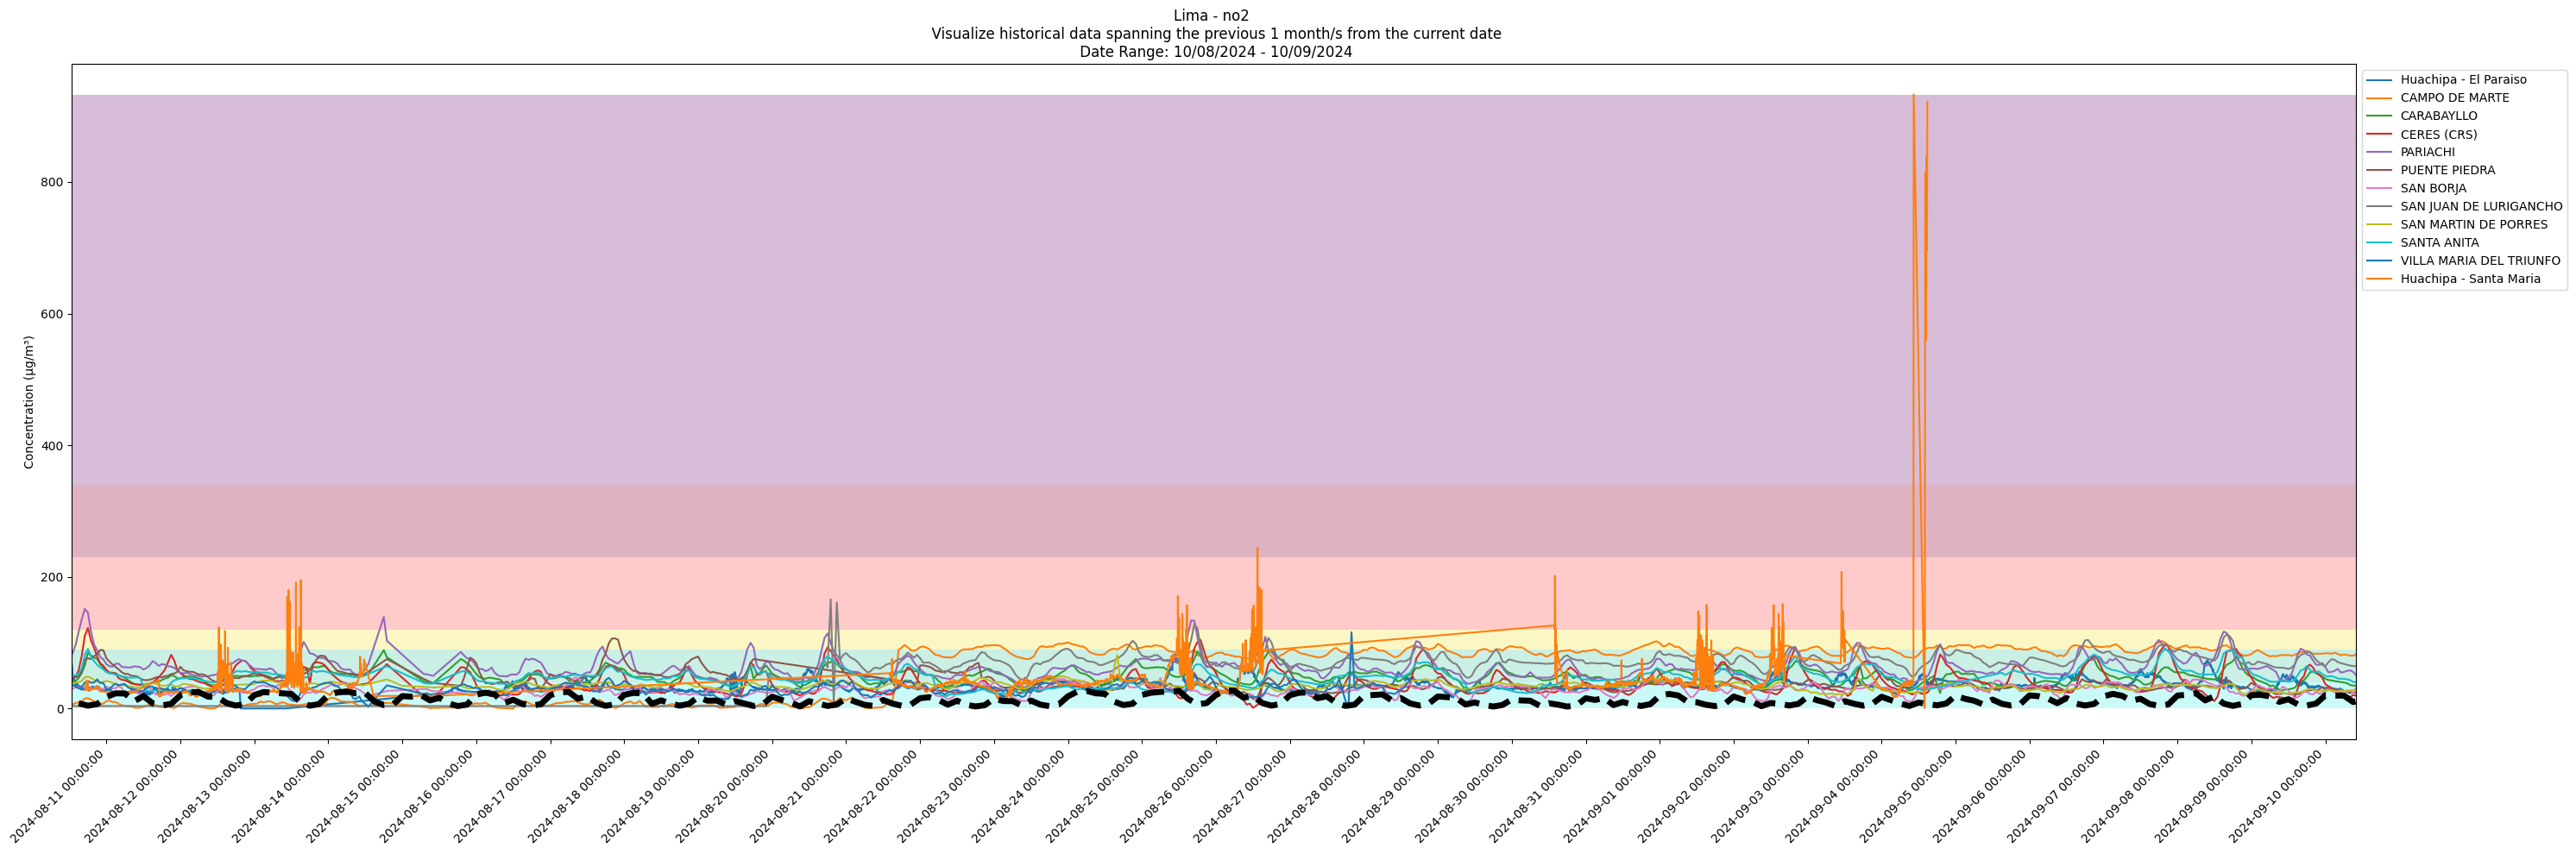

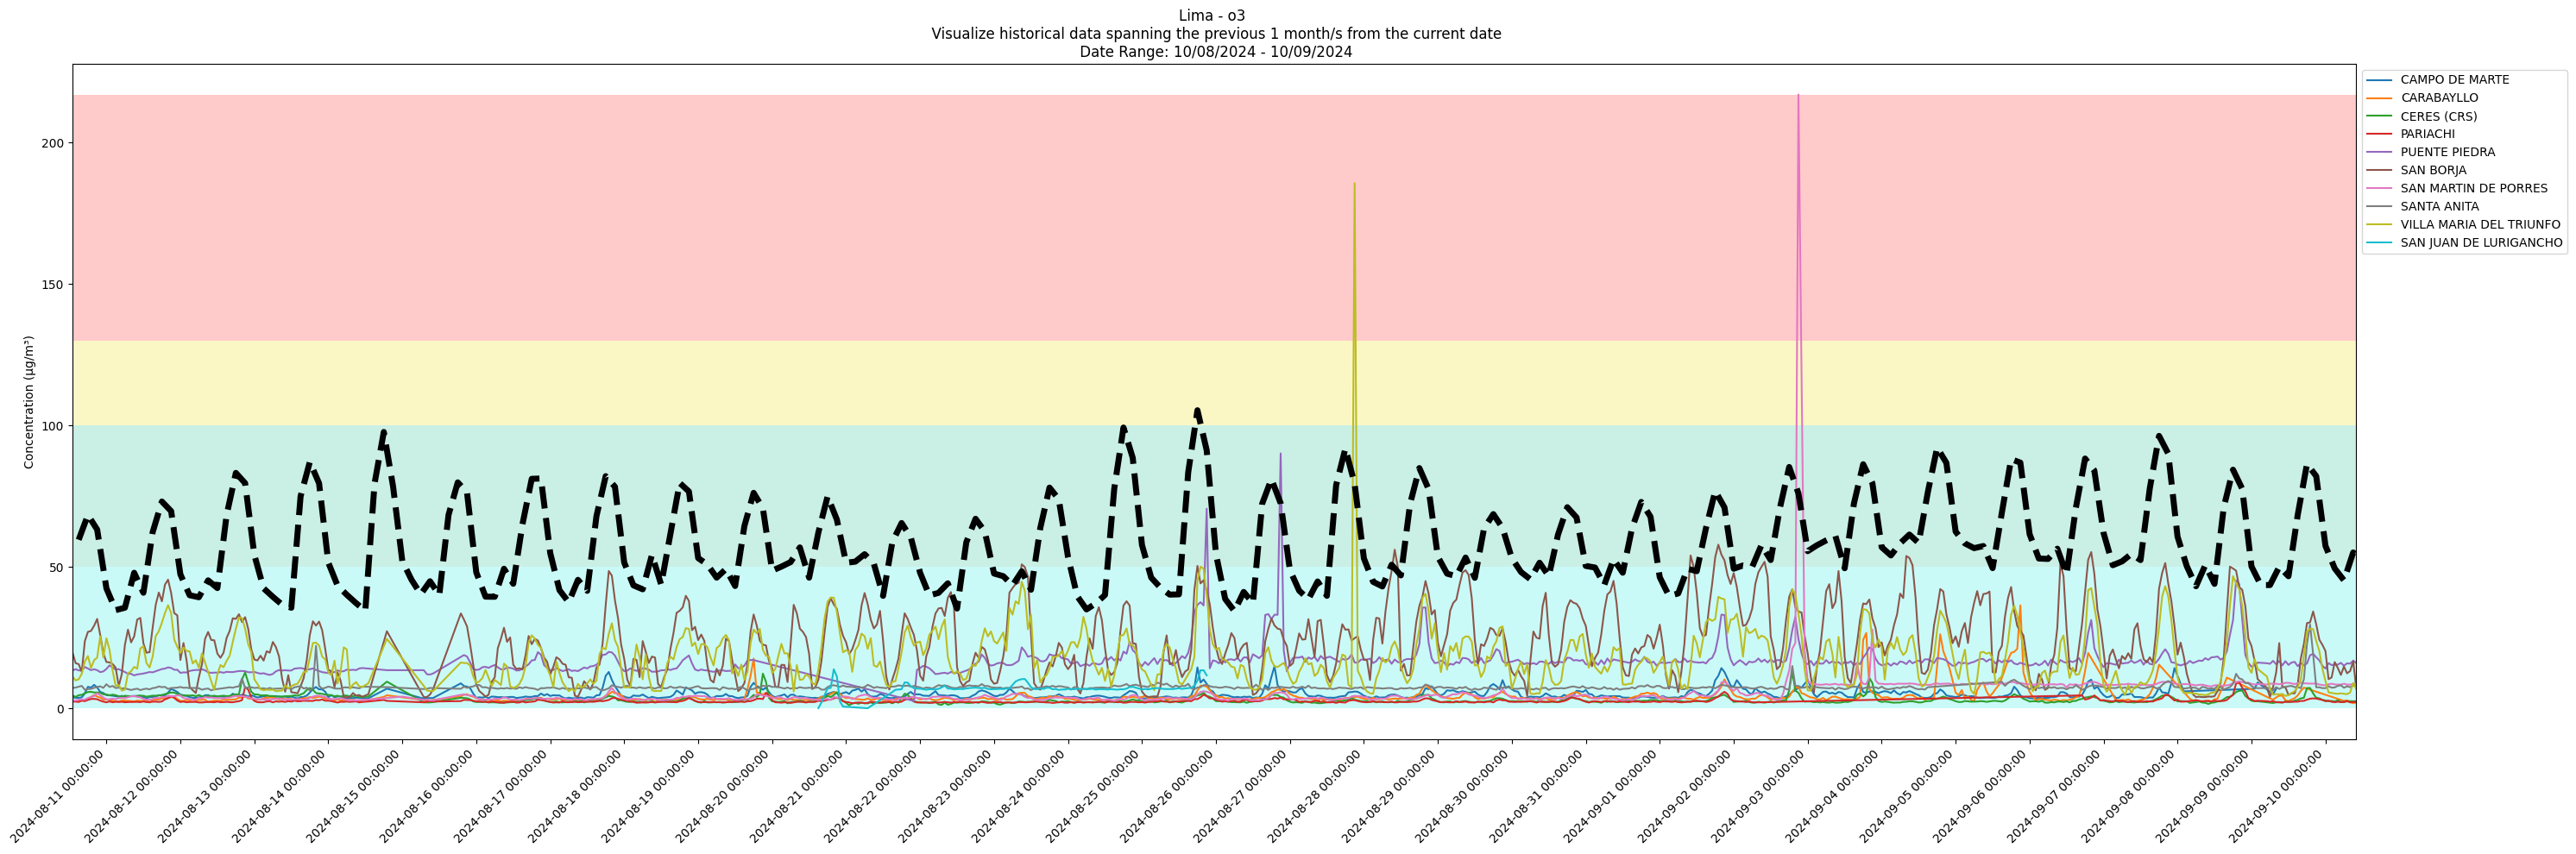

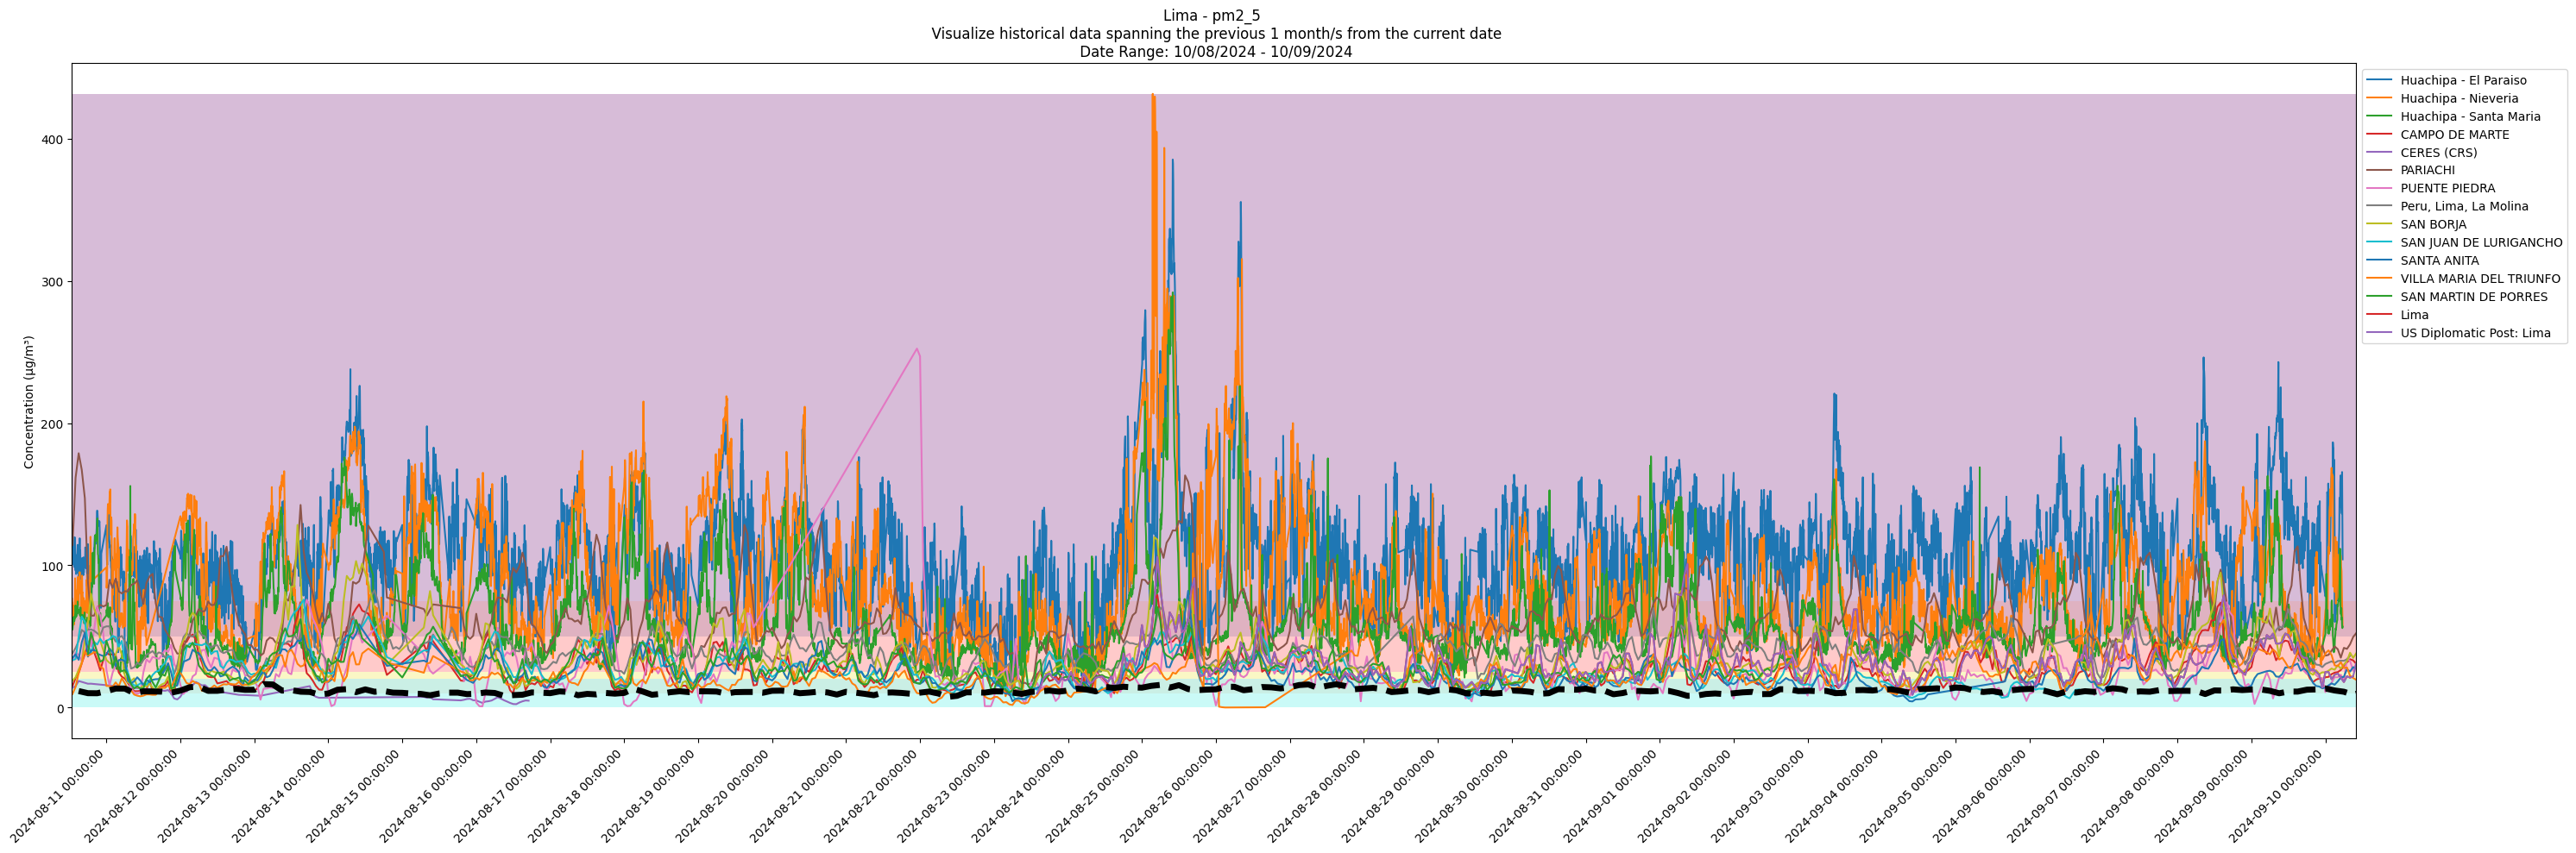

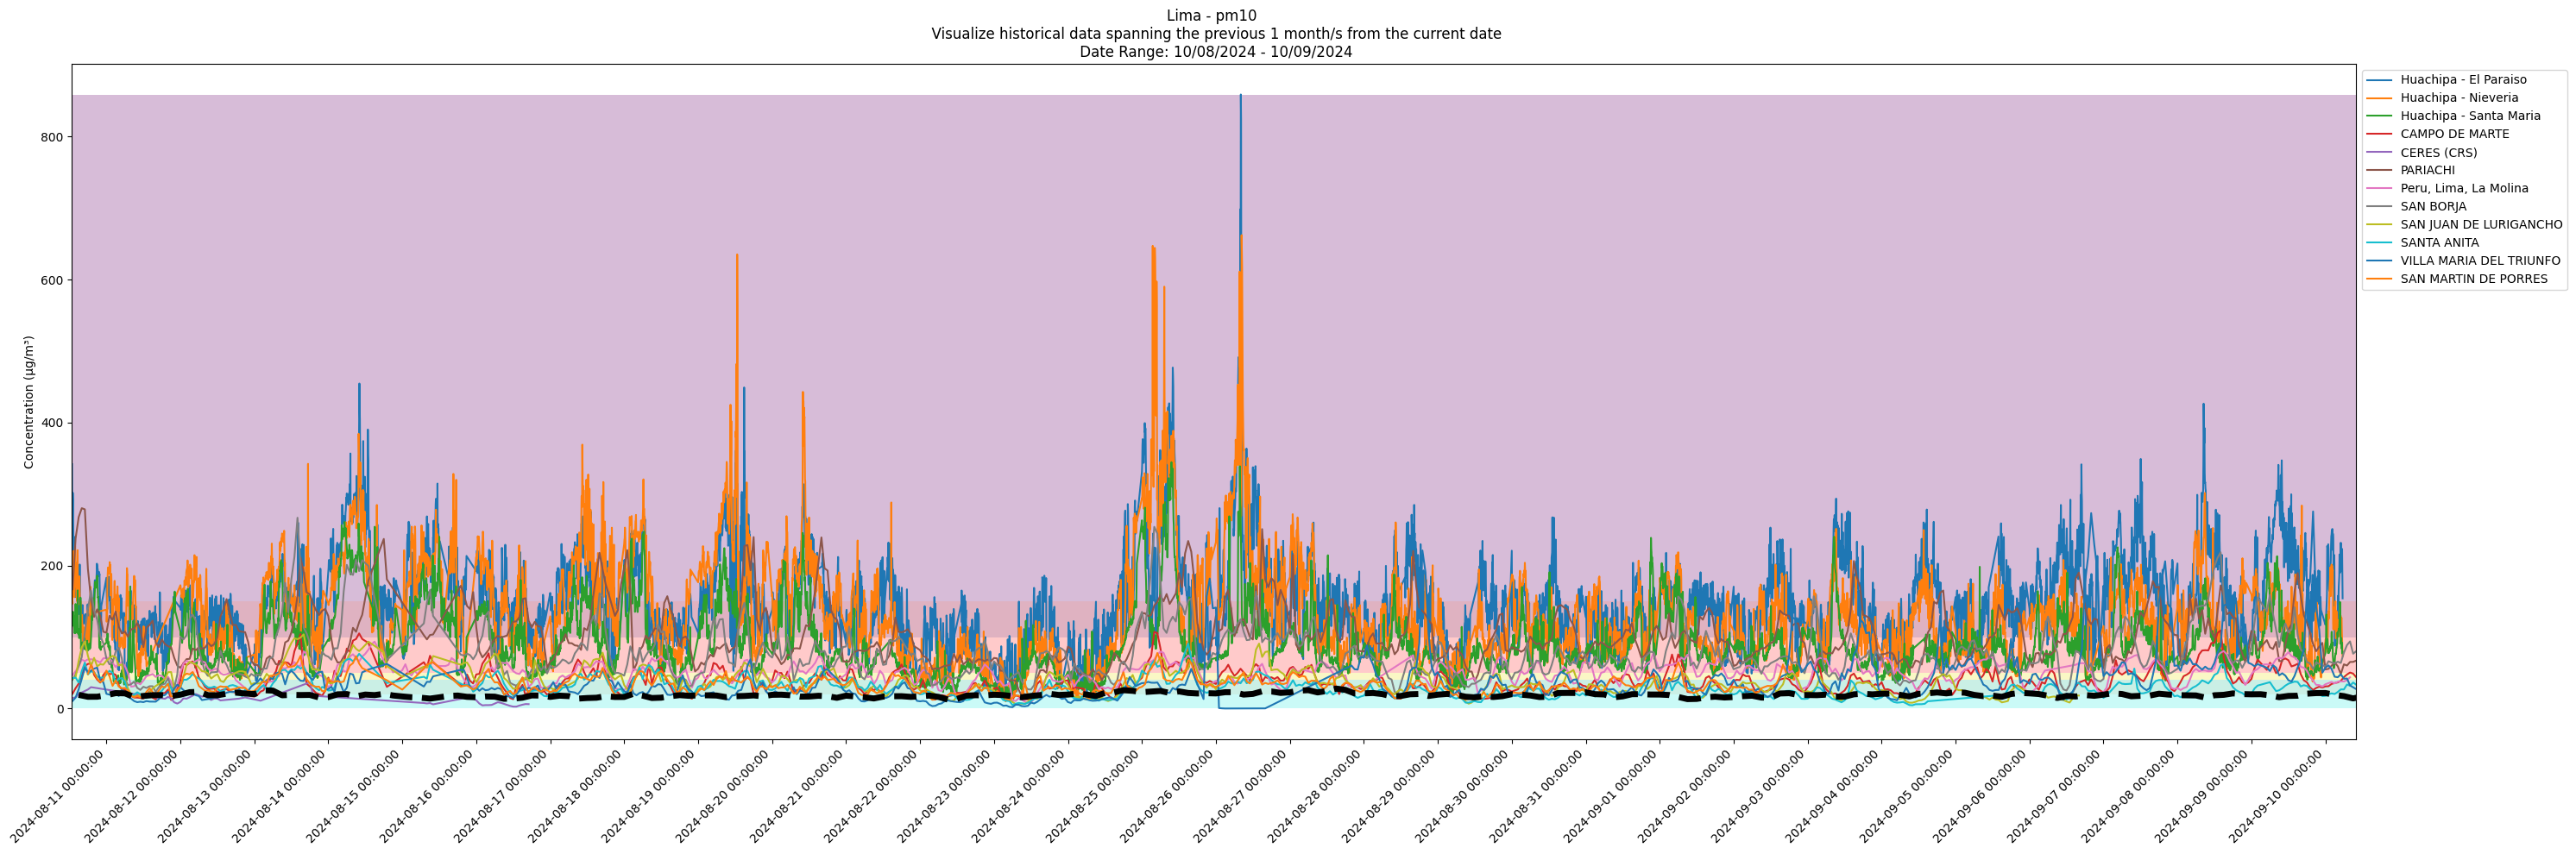

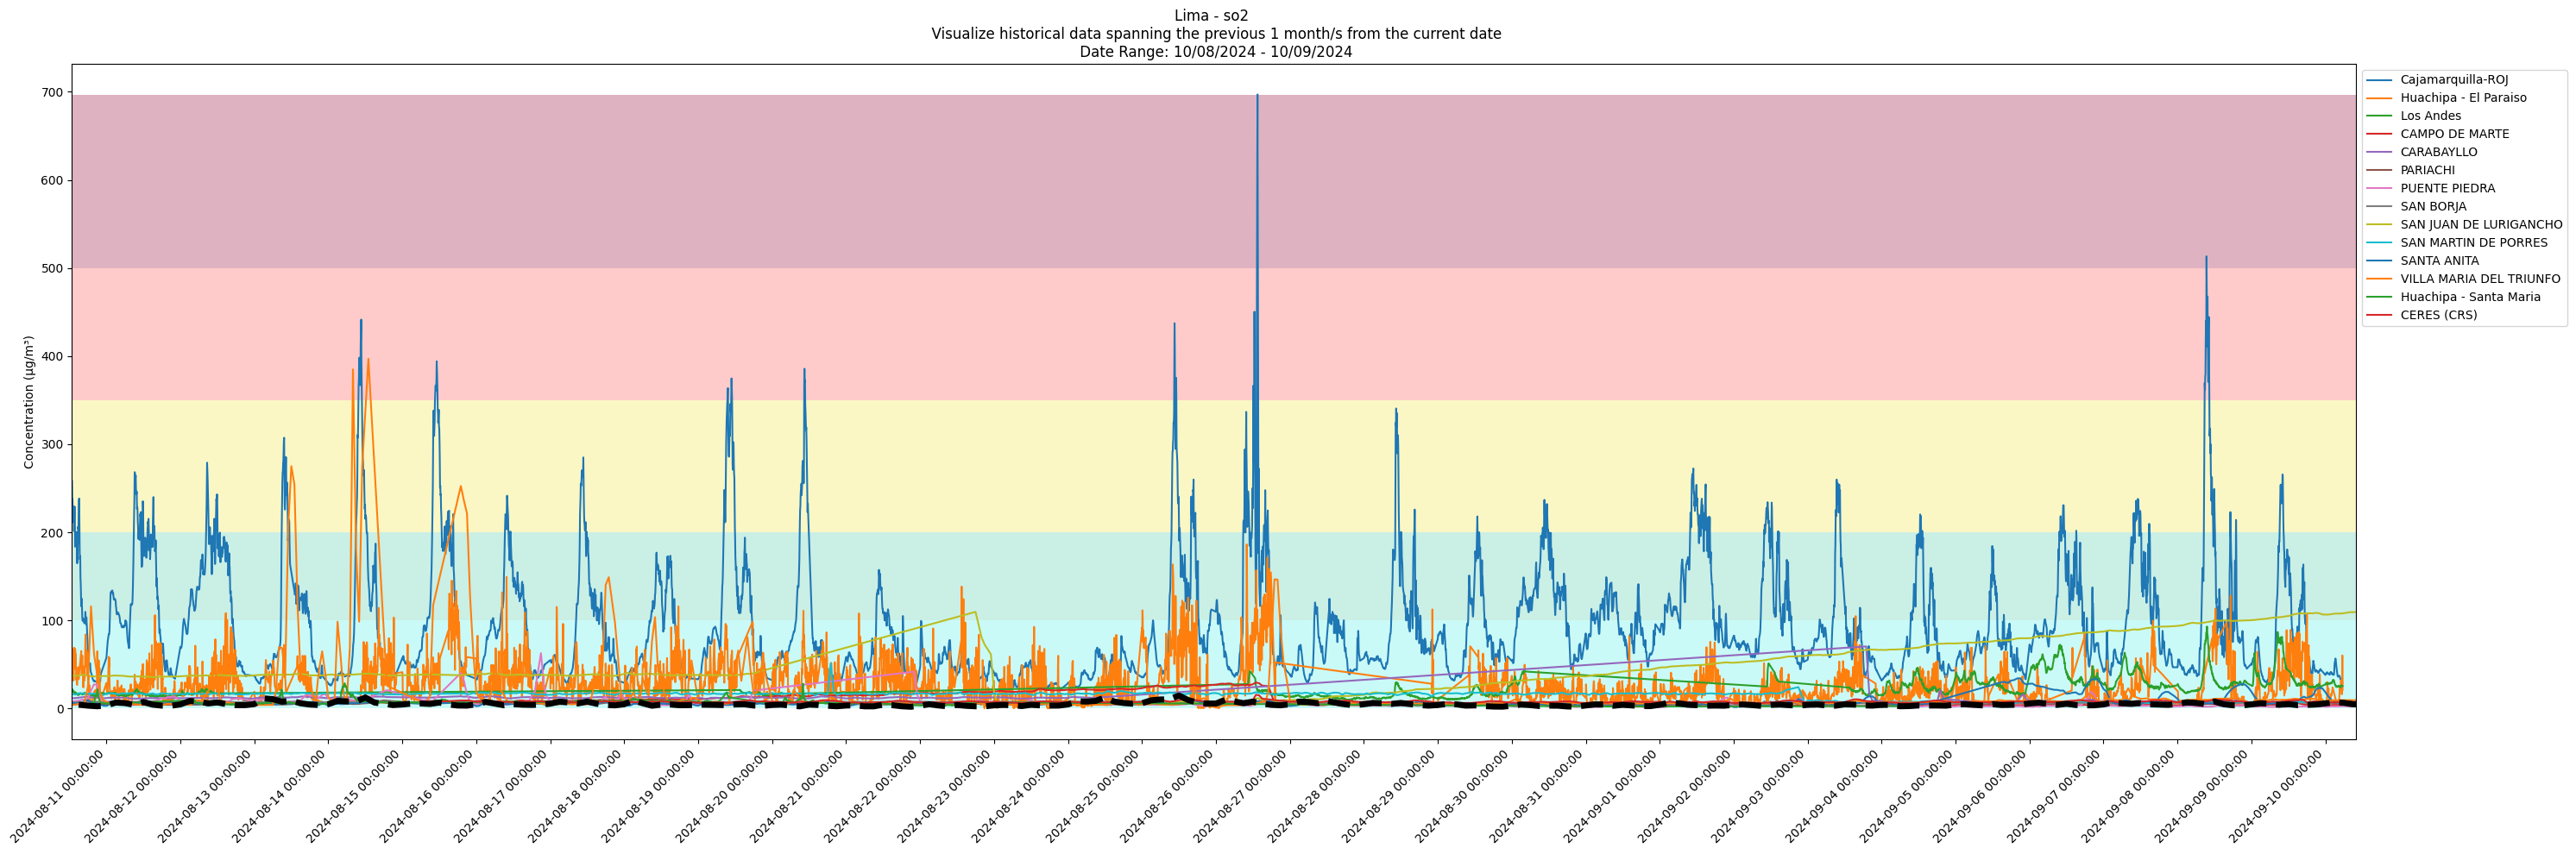

In [55]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import numpy as np

aqi_block_color_alpha = 0.3
hide_legend_if_exceed_stations = 20

aqi_ranges = {
    "o3": [
         50,
         100,
         130,
         240,
         380,
         800,
    ],
    "no2": [
         40,
         90,
         120,
         230,
         340,
         1000,
    ],
    "so2": [
        100,
        200,
        350,
        500,
         750,
        1250,
    ],
    "pm10": [
        20,
        40,
         50,
         100,
        150,
        1200,
    ],
    "pm2_5": [
        10,
        20,
         25,
         50,
         75,
         800,
    ],
}

def calculate_graph_width(processed_data, pollutant, base_width=10, max_width=30):
    max_data_points = max(
        len(station_data["times"]) 
        for station_data in processed_data[pollutant].values()
    )
    return min(max(base_width, max_data_points / 20), max_width)

def has_common_element(list1, list2):
    return bool(set(list1) & set(list2))

def create_colour_bar(from_value, to_value, max_value, colour):
    if max_value < to_value:
        ax.axhspan(from_value, max_value, color=colour, alpha=aqi_block_color_alpha, lw=0)
        return True
    else:
        ax.axhspan(from_value,  to_value, color=colour, alpha=aqi_block_color_alpha, lw=0)
        return False

def display_colour_bars(max_value):
    has_hit_max_value = False
    if not has_hit_max_value : has_hit_max_value = create_colour_bar(0, aqi_ranges[pollutant][0],max_value, '#50f0e5')
    if not has_hit_max_value : has_hit_max_value = create_colour_bar(aqi_ranges[pollutant][0], aqi_ranges[pollutant][1], max_value, '#50ccaa')
    if not has_hit_max_value : has_hit_max_value = create_colour_bar(aqi_ranges[pollutant][1], aqi_ranges[pollutant][2], max_value, '#f0e641')
    if not has_hit_max_value : has_hit_max_value = create_colour_bar(aqi_ranges[pollutant][2], aqi_ranges[pollutant][3], max_value, '#ff505080')
    if not has_hit_max_value : has_hit_max_value = create_colour_bar(aqi_ranges[pollutant][3], aqi_ranges[pollutant][4], max_value, '#960032')
    if not has_hit_max_value : has_hit_max_value = create_colour_bar(aqi_ranges[pollutant][4], max_value, max_value, '#7d2181')

for pollutant in in_situ_processed_data:
    graph_width = calculate_graph_width(in_situ_processed_data, pollutant)

    if not has_common_element(list(in_situ_processed_data[pollutant].keys()), list(stations_to_display)):
        continue

    fig, ax = plt.subplots(figsize=(graph_width, 10))
    
    all_times = []
    max_value = 0
    if len(forecast_processed_data[pollutant]["values"]) > 0:
        max_value = max(max_value, max(forecast_processed_data[pollutant]["values"]))
        ax.plot(forecast_processed_data[pollutant]["times"], forecast_processed_data[pollutant]["values"], color='#000000', linewidth=5, linestyle='dashed', zorder=100000000)
    
    station_count = 0    
    
    for measuring_station, station_data in in_situ_processed_data[pollutant].items():
        if measuring_station in list(stations_to_display):
            station_count = station_count + 1
            times = station_data["times"]
            values = station_data["values"]
            max_value = max(max_value, max(values))
            ax.plot(times, values, label=str(measuring_station))
            all_times.extend(times)

    ax.set_xlim(min(all_times), max(all_times))
    ax.xaxis.set_major_locator(mdates.DayLocator())
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d %H:%M:%S'))
    display_colour_bars(max_value)
    ax.set_ylabel('Concentration (µg/m³)')
    plt.title(f"{city} - {pollutant} \n  Visualize historical data spanning the previous {months_to_search} month/s from the current date \n Date Range: {start_date.strftime('%d/%m/%Y')} - {end_date.strftime('%d/%m/%Y')}")
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right")
    if station_count <= hide_legend_if_exceed_stations: plt.legend(bbox_to_anchor=(1, 1))
    plt.tight_layout()
    
    plt.show()